In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# dir_kr = './code&data/'
# parent_dir_initial = os.getcwd()
# sys.path.append(dir_kr+'/src')
if('src' not in os.getcwd()):
    parent_dir = os.getcwd()
    os.chdir(parent_dir+'/src')
# os.getcwd()
import kr_model
import kr_utils
import nelsonsiegelsvensson


(0.0, 6.0)

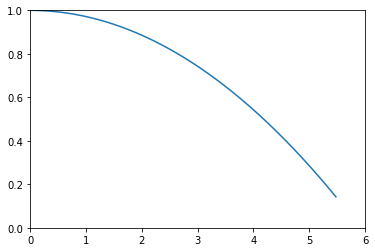

In [2]:
# true discount curve is y = 1/(1+x/365)
# simulation years around 5 2000 days and sample 100 bounds
# sample 10 times for cash flow and each cash flow is in [100,200]
# error term is normal
# cash flow is sampled around 
simu_days1 = np.arange(2000) +1
# simu_g = np.exp(-simu_days1/365)/(simu_days1/365)**(1/200)
simu_g = - (-simu_days1/365)**(2)/35 +1
# simu_g = np.exp(- simu_days1/365)
simu_y = -np.log(simu_g)/(simu_days1/365)
plt.plot(simu_days1/365,simu_g)
plt.ylim(0,1)
plt.xlim(0,6)

(0.0, 6.0)

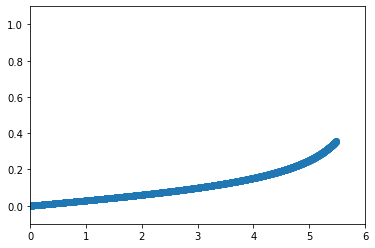

In [3]:
plt.scatter(simu_days1/365,simu_y)
plt.ylim(-0.1,1.1)
plt.xlim(0,6)

In [4]:
simu_cash_full = np.zeros((2000,200))
# simu_days_full = 

In [5]:
np.random.seed(5275)

simu_days_short = np.random.randint(1,501,(10,50))
simu_days_short2 = np.random.randint(1,1001,(10,50))
simu_days_long2 = np.random.randint(1,1501,(10,50))
simu_days_long = np.random.randint(1,2001,(10,50))
simu_days = np.hstack((simu_days_short,simu_days_short2,simu_days_long2,simu_days_long))
simu_days_sort = np.sort(simu_days, axis=0)
simu_cash = np.random.randint(100,201,(10,200))
simu_error = np.random.normal(0,2,200)

In [6]:
for i in range(200):
    simu_cash_full[simu_days_sort[:,i] -1 ,i] = simu_cash[:,i]

In [7]:
simu_dailyg =  - (-simu_days_sort/365)**(2)/35 +1
simu_price = np.diag(simu_dailyg.T@simu_cash) + simu_error

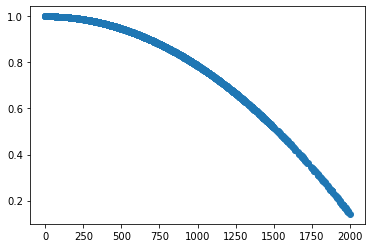

In [8]:
plt.scatter(simu_days_sort.reshape(-1,),simu_dailyg.reshape(-1,))

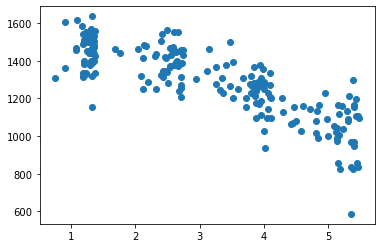

In [9]:
plt.scatter(simu_days_sort[9,]/365, simu_price)

In [10]:
### settings
# kernel hyper-parameters
alpha=0.05
delta=0.00
# delta=0.5
# max time to maturity in days
N=2000

K_simu=kr_model.generate_kernel_matrix(alpha, delta, N, N)

In [11]:
simu_data={}

# load price vector and cashflow matrix
B=simu_price
C=simu_cash_full.T
M=B.shape[0]

# get _ytm and _duration
_ytm, _dur=np.zeros(M), np.zeros(M) # _ytm and _duration
_ttm = np.zeros(M) # time to maturity in days
for i in range(M):
    time_to_cashflow_inday=np.where(C[i]!=0)[0]+1
    _ytm[i], _dur[i] = kr_utils.get_ytm_and_duration(C[i][time_to_cashflow_inday-1], time_to_cashflow_inday, B[i])
    _ttm[i] = max(time_to_cashflow_inday)

# get inverse of weights for fitting
# weights w is computed as w=1/_invw
_invw=(_dur*B)**2*M

simu_data={'B':B, 'C':C, '_ytm':_ytm, '_dur':_dur, '_ttm':_ttm, '_invw':_invw}


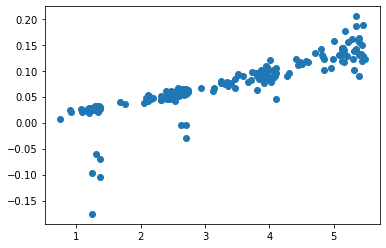

In [12]:
plt.scatter(simu_data["_ttm"]/365,simu_data["_ytm"])

In [13]:
### fit KR model on example dates

# KR ridge penalty term 
ridge=1 #lambda

simu_fit={}
    
simu_fit=kr_model.KR(C=simu_data['C'], # cashflow matrix
                        B=simu_data['B'], # price vector
                        ridge=ridge, # ridge hyper-parameter
                        inv_w=simu_data['_invw'], # inverse of the weighting vector
                        K=K_simu # kernel matrix
                    )
                               

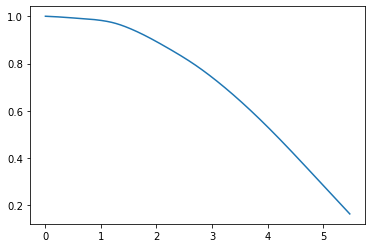

In [14]:
plt.plot(np.arange(1,2001)/365, simu_fit["g_solved"])

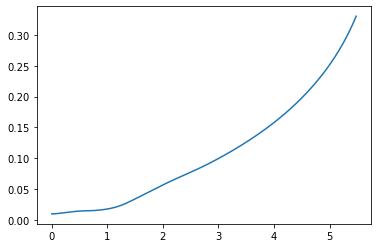

In [15]:
plt.plot(np.arange(1,2001)/365, simu_fit["y_solved"])

In [16]:
simu_fitted_price = []
for i in range(200):
    simu_fitted_price.append(simu_fit["g_solved"][simu_days_sort[:,i] - 1]@simu_cash[:,i])

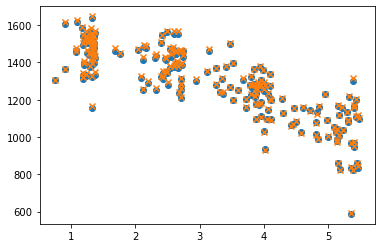

In [17]:
plt.scatter(simu_days_sort[9,]/365, simu_price)
plt.scatter(simu_data["_ttm"]/365, simu_fitted_price, marker="x")

### NSS

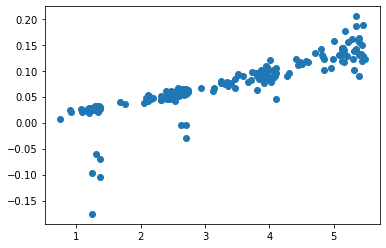

In [18]:
TimeVec = simu_data["_ttm"]/365
YieldVec = simu_data["_ytm"]
plt.scatter(TimeVec, YieldVec)

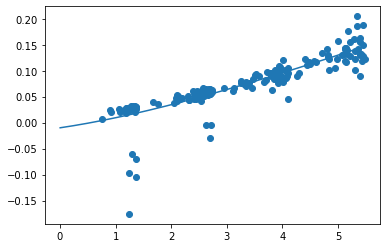

In [19]:
import matplotlib.pyplot as plt
import nelsonsiegelsvensson

TimeVec = simu_data["_ttm"]/365
YieldVec = simu_data["_ytm"]
beta0   = 0.1 # initial guess
beta1   = 0.1 # initial guess
beta2   = 0.1 # initial guess
beta3   = 0.1 # initial guess
lambda0 = 1 # initial guess
lambda1 = 1 # initial guess

max_ttm = int(max(simu_data["_ttm"]))
# date needed for predict
TimeResultVec = np.arange(1,1+max_ttm)/365
# TimeResultVec = dict_data["2013-12-31"]["ttm"]/365 # Maturities for yields that we are interested in

## Implementation
OptiParam = nelsonsiegelsvensson.NSSMinimize2(beta0, beta1, beta2, beta3, lambda0, lambda1, TimeVec, YieldVec) # The Nelder-Mead simplex algorithem is used to find the parameters that result in a curve with the minimum residuals compared to the market data.

# Print the yield curve with optimal parameter to compare with the data provided
y_simu_nss = nelsonsiegelsvensson.NelsonSiegelSvansson(TimeResultVec, OptiParam[0], OptiParam[1], OptiParam[2], OptiParam[3], OptiParam[4], OptiParam[5])

g_simu_nss = nelsonsiegelsvensson.convert_y_to_g(y_simu_nss, TimeResultVec)
# plt.scatter(TimeResultVec, g_x)
plt.plot(TimeResultVec, y_simu_nss)
plt.scatter(simu_data["_ttm"]/365,simu_data["_ytm"])
plt.show()

In [20]:
simu_fitted_price_nss = []
for i in range(200):
    simu_fitted_price_nss.append(g_simu_nss[simu_days_sort[:,i] - 1]@simu_cash[:,i])

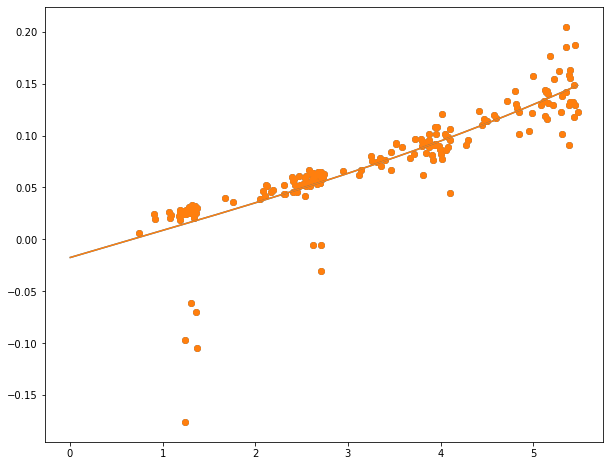

In [21]:
import pandas as pd
import copy
spline_data = copy.deepcopy(simu_data)
spline_data_yt = pd.DataFrame((spline_data["_ttm"], spline_data["_ytm"]))
spline_data_yt = spline_data_yt.T
spline_data_yt = spline_data_yt.sort_values(by=0)
from scipy.interpolate import splev, splrep
from scipy import interpolate
x_spline = (spline_data_yt[0]/365).to_numpy()
y_spline = spline_data_yt[1].to_numpy()

# use bc_type = 'natural' adds the constraints as we described above
f = splrep(x_spline, y_spline, s=2)
x_spline_date = TimeResultVec
y_simu_spline = splev(x_spline_date, f, der=0)
plt.figure(figsize = (10,8))
plt.plot(x_spline_date, y_simu_spline)
plt.scatter(x_spline, y_spline)

g_simu_spline = nelsonsiegelsvensson.convert_y_to_g(y_simu_spline, x_spline_date)
plt.plot(x_spline_date, y_simu_spline)
plt.scatter(simu_data["_ttm"]/365,simu_data["_ytm"])

In [22]:
simu_fitted_price_spline = []
for i in range(200):
    simu_fitted_price_spline.append(g_simu_spline[simu_days_sort[:,i] - 1]@simu_cash[:,i])

Text(0.5, 0, 'Time to maturity in years')

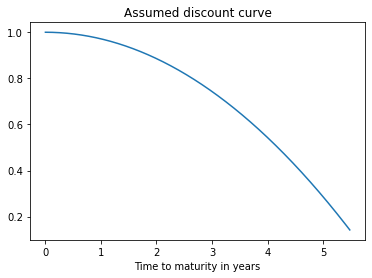

In [23]:
plt.plot(simu_days1/365,simu_g)
plt.title("Assumed discount curve")
plt.xlabel('Time to maturity in years')

Text(0.5, 0, 'Time to maturity in years')

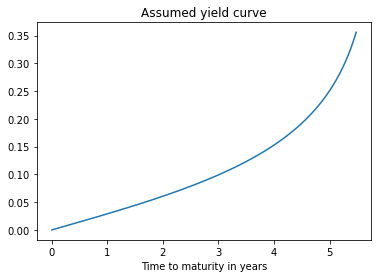

In [24]:
plt.plot(simu_days1/365,simu_y)
plt.title("Assumed yield curve")
plt.xlabel('Time to maturity in years')

Text(0.5, 0, 'Time to maturity in years')

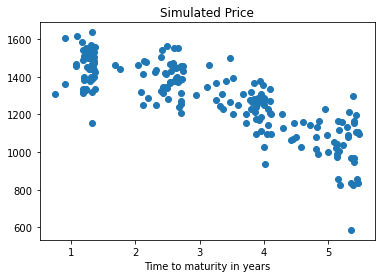

In [25]:
plt.scatter(simu_days_sort[9,]/365, simu_price)
plt.title("Simulated Price")
plt.xlabel('Time to maturity in years')

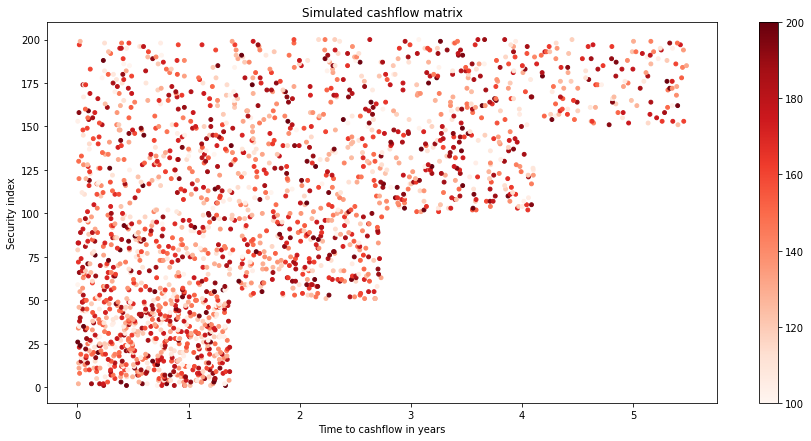

In [28]:
B=simu_data['B']
C=simu_data['C']
M=B.shape[0]

time_to_cashflow_inday=[]
for i in range(M):
    time_to_cashflow_inday.append(np.where(C[i]!=0)[0]+1)

xs=np.concatenate(time_to_cashflow_inday)
ys=np.concatenate([i* np.ones(time_to_cashflow_inday[i].shape) for i in range(M)])
color=np.concatenate([C[i, time_to_cashflow_inday[i]-1] for i in range(M)])


fig=plt.figure(figsize=(15,7))
ax=fig.add_subplot(1,1,1)
im = ax.scatter(x=xs/365, y=1+ys, c=color, cmap='Reds', alpha=1, s=15)
fig.colorbar(im,ax=ax)


ax.set_xlabel('Time to cashflow in years');
ax.set_ylabel('Security index');
ax.set_title('Simulated cashflow matrix');


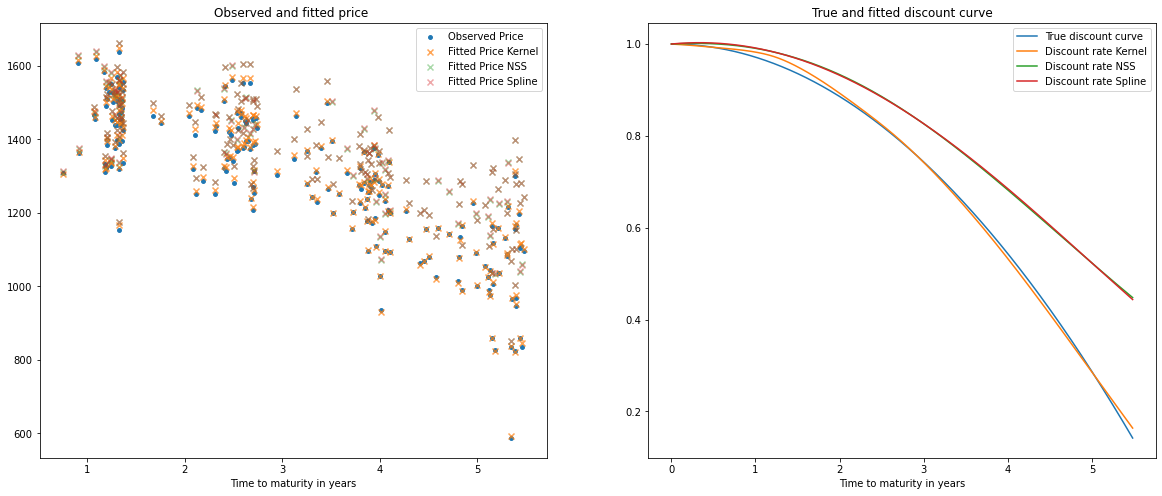

In [27]:
ttm = np.zeros(M) # time to maturity in days

for i in range(M):
    time_to_cashflow_inday=np.where(simu_data["C"][i]!=0)[0]+1

    ttm[i] = max(time_to_cashflow_inday)

fig=plt.figure(figsize=(20,8))
ax_1,ax_2 =fig.add_subplot(1,2,1), fig.add_subplot(1,2,2)


ax_1.scatter(ttm/365, simu_data['B'], marker='o', s=15, label='Observed Price');
ax_1.scatter(ttm/365, simu_fitted_price, marker='x',alpha=0.7,  label='Fitted Price Kernel');
ax_1.scatter(ttm/365, simu_fitted_price_nss, marker='x', alpha=0.4, label='Fitted Price NSS')
ax_1.scatter(ttm/365, simu_fitted_price_spline, marker='x', alpha=0.4, label='Fitted Price Spline')

ax_2.plot(simu_days1/365, simu_g, label='True discount curve');
ax_2.plot(simu_days1/365, simu_fit["g_solved"], label='Discount rate Kernel');
ax_2.plot(simu_days1/365, g_simu_nss, label='Discount rate NSS');
ax_2.plot(simu_days1/365, g_simu_spline, label='Discount rate Spline')

ax_1.set_title('Observed and fitted price ');
ax_2.set_title('True and fitted discount curve');

for ax in [ax_1, ax_2]:
    ax.legend();
    ax.set_xlabel('Time to maturity in years');